In [1]:
import cloudpickle as pickle
import numpy as np
import pandas as pd
import requests
from time import sleep
import os.path

In [2]:
pd.set_option('display.max_rows', 500)

In [5]:
force_refresh = False
directory = './'
if not force_refresh and os.path.isfile('data.pickle'):
    print('Loading from cache')
    with open(os.path.join(directory, 'data.pickle'), 'rb') as f:
        meta, miners = pickle.load(f)
else:
    meta = {}
    miners = []
    for i in range(45):
        uri = f'https://filfox.info/api/v1/miner/list/power?pageSize=100&page={i}'
        response = requests.get(uri)
        if not response.ok:
            break
        json = response.json()
    #     display(json)
        miners.extend(json['miners'])
        del json['miners']
        meta = json
        sleep(1)
    
    with open(os.path.join(directory, 'data.pickle'), 'wb') as f:
        pickle.dump((meta, miners), f)



Loading from cache


In [6]:
len(miners)

4037

In [7]:
from datetime import datetime
    
def load_rewards(address, force_refresh=False):
    directory = '31d_rewards'
    filename = os.path.join(directory, f'rewards_{address}.pickle')
    if not force_refresh and os.path.isfile(filename):
        display(f'{address} cached')
        with open(filename, 'rb') as f:
            return pickle.load(f)

    i = 0
    rewards = []
    while not rewards or (datetime.now() - rewards[-1][0]).days <= 31:
        uri = f'https://filfox.info/api/v1/address/{address}/blocks?pageSize=100&page={i}'
        display(uri)
        response = requests.get(uri)
        if not response.ok:
            break
        json = response.json()
        if not json['blocks']:
            break

        rewards.extend((datetime.fromtimestamp(block['timestamp']), block['reward']) for block in json['blocks'])
        
        display(f'Fetched {address} up to {rewards[-1][0]} {(datetime.now() - rewards[-1][0]).days} days')
        sleep(1)
        i += 1
    with open(filename, 'wb') as f:
        pickle.dump(rewards, f)
        
    return rewards

rewards = {}
with open(os.path.join(directory, '31d_rewards.pickle'), 'rb') as f:
    rewards = pickle.load(f)
# for m in miners:
#     address = m['address']
#     rewards[address] = load_rewards(address)
    
# with open(os.path.join(directory, '31d_rewards.pickle'), 'wb') as f:
#     rewards = pickle.dump(rewards, f)

In [8]:
len(rewards)

4037

In [9]:
force_refresh = False

powers = {}
with open(os.path.join(directory, 'powers.pickle'), 'rb') as f:
    powers = pickle.load(f)

# for m in miners:
#     address = m['address']
#     filename = f'power_{address}.pickle'

#     if not force_refresh and os.path.isfile(filename):
#         display(f'{address} cached')
#         with open(os.path.join(directory, filename), 'rb') as f:
#             power = pickle.load(f)
#         powers[address] = power
#         continue

#     uri = f'https://filfox.info/api/v1/address/{address}/power-stats'
#     response = requests.get(uri)
#     if not response.ok:
#         continue

#     json = response.json()
#     power = [(datetime.fromtimestamp(power['timestamp']), power['qualityAdjPower']) for power in json]
#     powers[address] = power

#     with open(os.path.join(directory, filename), 'wb') as f:
#         pickle.dump(power, f)

#     display(f'Fetched {address}')
# #     display(power)
#     sleep(1)

In [10]:
len(powers)

4037

In [11]:
import pandas as pd

df = pd.DataFrame([(k, time, reward) for k, v in rewards.items() for time, reward in v])
df.columns = ('address', 'time', 'reward')
# df = df.set_index(keys=['address', 'time'])
# df['reward'] = pd.to_numeric(df['reward'])
df['reward'] = df['reward'].astype('float64') / 10e17
df

,address,time,reward
0,f0688165,2022-07-30 23:30:00,20.512954
1,f0688165,2022-07-30 23:11:00,20.513352
2,f0688165,2022-07-30 23:00:30,20.513392
3,f0688165,2022-07-30 22:25:00,20.510210
4,f0688165,2022-07-30 22:20:00,20.513573
...,...,...,...
654950,f029665,2022-01-29 09:22:00,22.318600
654951,f029665,2022-01-28 15:41:30,22.326923
654952,f029665,2022-01-26 09:09:00,22.352476
654953,f029665,2022-01-22 12:44:30,22.395388


In [12]:
df_powers = pd.DataFrame([(k, time, power) for k, v in powers.items() for time, power in v])
df_powers.columns = ('address', 'time', 'power')
# df_powers = df_powers.set_index(keys=['address', 'time'])
df_powers['power'] = pd.to_numeric(df_powers['power']) / (1024 ** 4)
df_powers

,address,time,power
0,f0688165,2020-09-23 03:16:00,0.00000
1,f0688165,2020-10-22 12:32:00,0.00000
2,f0688165,2020-11-20 20:47:30,0.00000
3,f0688165,2020-12-20 06:03:30,0.00000
4,f0688165,2021-01-18 15:19:00,0.00000
...,...,...,...
96883,f0121718,2022-04-04 23:57:00,1646.28125
96884,f0121718,2022-05-04 09:50:30,1572.87500
96885,f0121718,2022-06-02 19:44:30,1646.28125
96886,f0121718,2022-07-02 05:38:30,1253.71875


In [13]:
df_all = pd.merge_asof(df.sort_values('time'), df_powers.sort_values(['time']), by=['address'], on=['time'], direction='backward')
df_all

,address,time,reward,power
0,f01152,2020-08-28 05:11:30,7.748567,NaN
1,f01152,2020-08-28 10:21:30,7.784170,NaN
2,f01152,2020-08-28 10:25:00,7.783412,NaN
3,f01152,2020-08-28 16:09:00,7.822669,NaN
4,f01152,2020-08-28 20:43:30,7.875819,NaN
...,...,...,...,...
654950,f086572,2022-07-31 13:39:00,20.505328,577.468750
654951,f0413323,2022-07-31 13:45:00,20.504269,735.437500
654952,f0232650,2022-07-31 14:03:00,20.504666,185.562500
654953,f01471413,2022-07-31 14:19:00,20.507993,101.531250


In [14]:
address = 'f01822659'
time = datetime.fromisoformat('2022-07-01')
(address, time)

('f01822659', datetime.datetime(2022, 7, 1, 0, 0))

In [15]:
df[(df.address == address) & (df.time >= time)]

,address,time,reward
217487,f01822659,2022-07-31 00:24:30,20.509521
217488,f01822659,2022-07-30 18:35:00,20.512675
217489,f01822659,2022-07-30 11:08:30,20.517682
217490,f01822659,2022-07-30 11:03:00,20.516728
217491,f01822659,2022-07-30 10:10:00,20.515038
217492,f01822659,2022-07-30 06:10:00,20.516948
217493,f01822659,2022-07-30 06:09:30,20.520364
217494,f01822659,2022-07-30 03:27:30,20.521056
217495,f01822659,2022-07-30 02:20:00,20.517610
217496,f01822659,2022-07-30 00:12:30,20.518381


In [16]:
df_powers[df_powers.address == address]

,address,time,power
5928,f01822659,2020-09-23 03:50:30,0.0000
5929,f01822659,2020-10-22 13:40:30,0.0000
5930,f01822659,2020-11-20 22:30:30,0.0000
5931,f01822659,2020-12-20 08:20:30,0.0000
5932,f01822659,2021-01-18 18:10:30,0.0000
5933,f01822659,2021-02-17 04:00:30,0.0000
5934,f01822659,2021-03-18 14:51:00,0.0000
5935,f01822659,2021-04-17 00:41:00,0.0000
5936,f01822659,2021-05-16 10:31:00,0.0000
5937,f01822659,2021-06-14 20:21:00,0.0000


In [17]:
# df_joined = df_all[(df_all.address == address) & (df_all.time >= time) & (~pd.isna(df_all.power))]
df_joined = df_all[(~pd.isna(df_all.power)) & (df_all.time >= time)]
df_joined

,address,time,reward,power
233942,f01170399,2022-07-01 00:00:00,20.782188,1724.875000
233943,f01472333,2022-07-01 00:00:00,20.783153,7846.781250
233944,f01169723,2022-07-01 00:00:00,20.782239,26454.937500
233945,f01075159,2022-07-01 00:00:00,20.782669,29640.589077
233946,f0143162,2022-07-01 00:00:00,20.782185,2335.625000
...,...,...,...,...
654950,f086572,2022-07-31 13:39:00,20.505328,577.468750
654951,f0413323,2022-07-31 13:45:00,20.504269,735.437500
654952,f0232650,2022-07-31 14:03:00,20.504666,185.562500
654953,f01471413,2022-07-31 14:19:00,20.507993,101.531250


In [18]:
df_joined['reward_by_power'] = df_joined.reward / df_joined.power
df_joined

/tmp/ipykernel_446262/4178590088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['reward_by_power'] = df_joined.reward / df_joined.power


,address,time,reward,power,reward_by_power
233942,f01170399,2022-07-01 00:00:00,20.782188,1724.875000,0.012049
233943,f01472333,2022-07-01 00:00:00,20.783153,7846.781250,0.002649
233944,f01169723,2022-07-01 00:00:00,20.782239,26454.937500,0.000786
233945,f01075159,2022-07-01 00:00:00,20.782669,29640.589077,0.000701
233946,f0143162,2022-07-01 00:00:00,20.782185,2335.625000,0.008898
...,...,...,...,...,...
654950,f086572,2022-07-31 13:39:00,20.505328,577.468750,0.035509
654951,f0413323,2022-07-31 13:45:00,20.504269,735.437500,0.027880
654952,f0232650,2022-07-31 14:03:00,20.504666,185.562500,0.110500
654953,f01471413,2022-07-31 14:19:00,20.507993,101.531250,0.201987


<AxesSubplot:xlabel='power', ylabel='reward_by_power'>

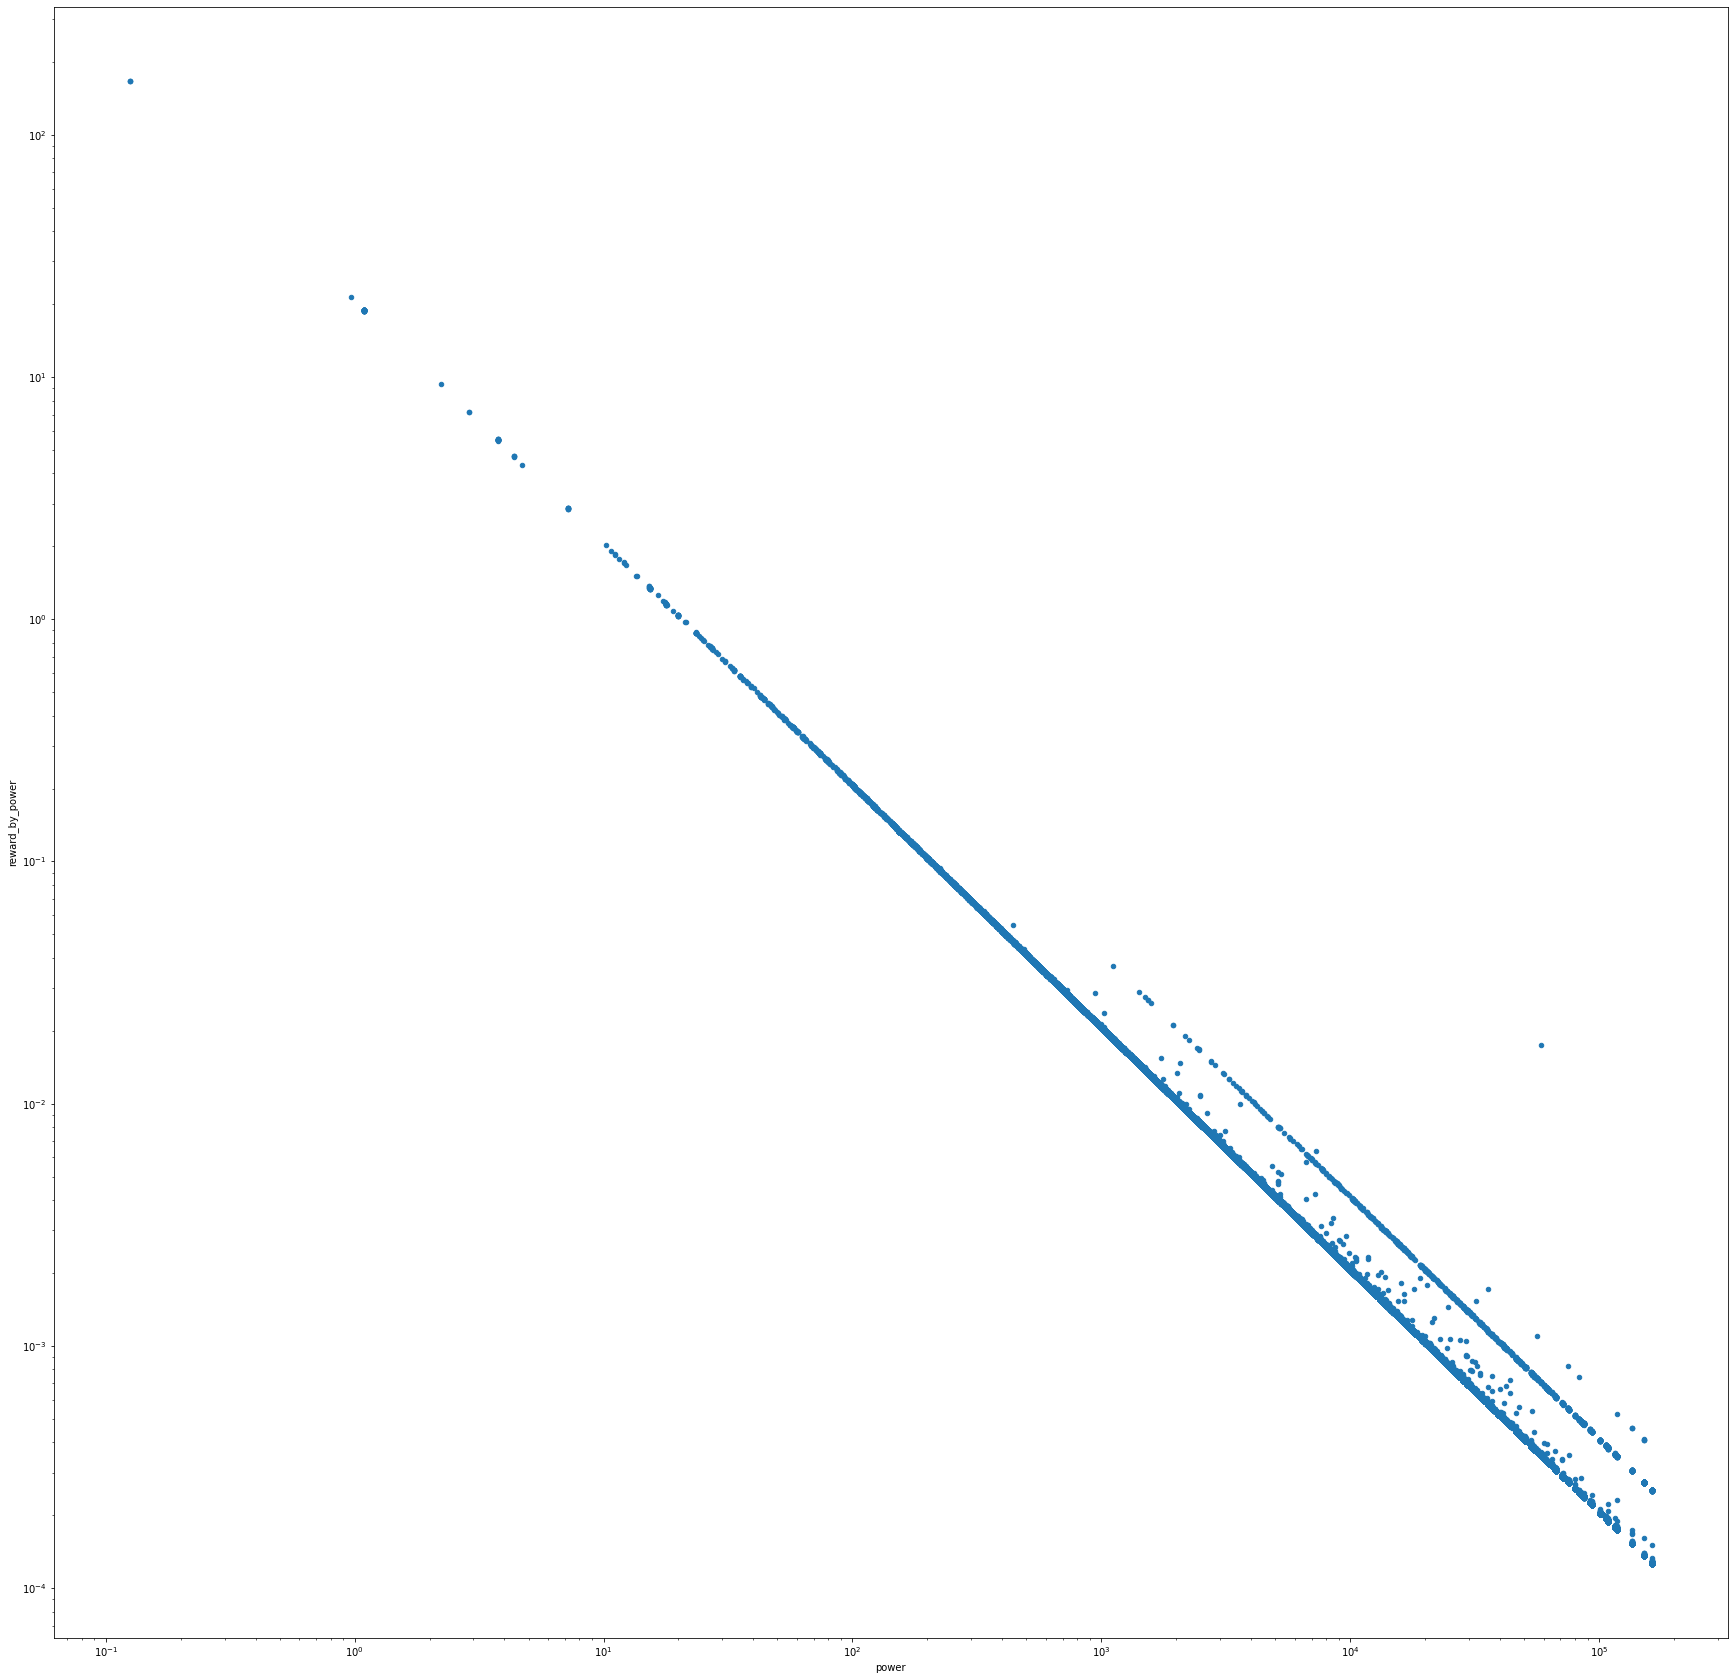

In [19]:
df_joined.plot(x='power', y='reward_by_power', logx=True, logy=True, kind='scatter', figsize=(30,30))

In [20]:
df_agg = df_joined.groupby(by=['address', 'power']).agg(['min', 'max', 'count', 'sum'])
# df_agg.columns = df_agg.columns.to_flat_index()
df_agg = df_agg.reset_index()
df_agg.sort_values('power')[df_agg.power > 0]

/tmp/ipykernel_446262/1526460585.py:1: FutureWarning: ['time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_agg = df_joined.groupby(by=['address', 'power']).agg(['min', 'max', 'count', 'sum'])
/tmp/ipykernel_446262/1526460585.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_agg.sort_values('power')[df_agg.power > 0]


address          power     reward                                 \
                                      min        max count           sum   
2862  f01852193       0.125000  20.777319  20.782333     3     62.341575   
2718  f01832393       0.967555  20.771817  20.771817     1     20.771817   
2965  f01873155       1.093750  20.508660  20.743225    31    639.173398   
916   f01191451       2.218750  20.730275  20.730275     1     20.730275   
2383  f01756867       2.875000  20.570785  20.603514     2     41.174299   
...         ...            ...        ...        ...   ...           ...   
1152   f0123261  117824.312500  20.509902  61.868458  2479  51927.374697   
1153   f0123261  117875.750000  20.776827  41.564805    50   1059.777700   
1306   f0127595  135172.187500  20.509794  62.033970  2855  59873.246225   
4022   f0688165  151201.562500  20.510210  62.143084  3331  70559.680479   
811   f01173170  162829.062500  20.510004  41.558938  3413  71868.541166   

     reward_by_power                                
                 min         max count         sum  
2862      166.218551  166.258664     3  498.732597  
2718       21.468357   21.468357     1   21.468357  
2965       18.750775   18.965235    31  584.387107  
916         9.343223    9.343223     1    9.343223  
2383        7.155055    7.166440     2   14.321495  
...              ...         ...   ...         ...  
1152        0.000174    0.000525  2479    0.440719  
1153        0.000176    0.000353    50    0.008991  
1306        0.000152    0.000459  2855    0.442941  
4022        0.000136    0.000411  3331    0.466660  
811         0.000126    0.000255  3413    0.441374  

[4632 rows x 10 columns]

<AxesSubplot:xlabel='power', ylabel='(reward_by_power, count)'>

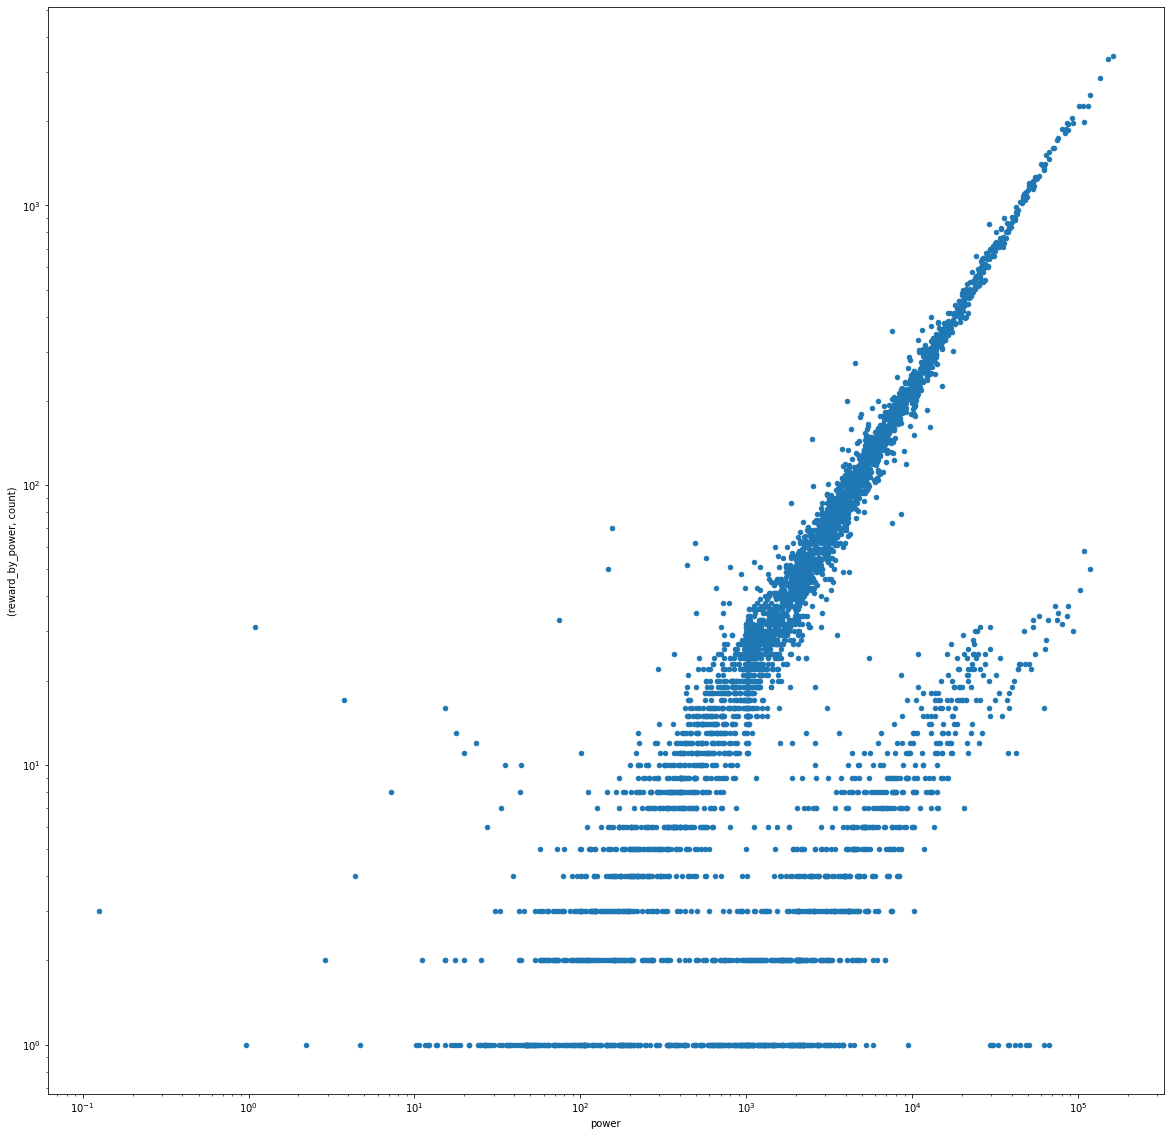

In [21]:
df_agg.plot(x='power', y=('reward_by_power', 'count'), logx=True, logy=True, kind='scatter', figsize=(20,20))

In [22]:
df_joined

,address,time,reward,power,reward_by_power
233942,f01170399,2022-07-01 00:00:00,20.782188,1724.875000,0.012049
233943,f01472333,2022-07-01 00:00:00,20.783153,7846.781250,0.002649
233944,f01169723,2022-07-01 00:00:00,20.782239,26454.937500,0.000786
233945,f01075159,2022-07-01 00:00:00,20.782669,29640.589077,0.000701
233946,f0143162,2022-07-01 00:00:00,20.782185,2335.625000,0.008898
...,...,...,...,...,...
654950,f086572,2022-07-31 13:39:00,20.505328,577.468750,0.035509
654951,f0413323,2022-07-31 13:45:00,20.504269,735.437500,0.027880
654952,f0232650,2022-07-31 14:03:00,20.504666,185.562500,0.110500
654953,f01471413,2022-07-31 14:19:00,20.507993,101.531250,0.201987


In [23]:
df_joined[(df_joined.power >= 100) & (df_joined.power <= 1000)].describe()

,reward,power,reward_by_power
count,10129.000000,10129.000000,10129.000000
mean,20.643450,586.906005,0.046862
std,0.107985,245.831930,0.033541
min,20.503765,100.156250,0.020505
25%,20.572931,401.312500,0.025924
50%,20.640315,592.468750,0.034922
75%,20.710635,794.559408,0.051382
max,26.947928,1000.000000,0.207028


In [24]:
df_joined[(df_joined.power >= 10) & (df_joined.power <= 1000)]

,address,time,reward,power,reward_by_power
233950,f01853616,2022-07-01 00:00:30,20.783570,101.625000,0.204512
233959,f01780739,2022-07-01 00:01:30,20.782324,421.072228,0.049356
233960,f01267055,2022-07-01 00:01:30,20.782154,625.250000,0.033238
233985,f01853616,2022-07-01 00:03:30,20.783166,101.625000,0.204508
233991,f097618,2022-07-01 00:04:00,20.782272,301.375000,0.068958
...,...,...,...,...,...
654950,f086572,2022-07-31 13:39:00,20.505328,577.468750,0.035509
654951,f0413323,2022-07-31 13:45:00,20.504269,735.437500,0.027880
654952,f0232650,2022-07-31 14:03:00,20.504666,185.562500,0.110500
654953,f01471413,2022-07-31 14:19:00,20.507993,101.531250,0.201987


/tmp/ipykernel_446262/3101930119.py:1: FutureWarning: ['time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_sum = (df_joined[(df_joined.power >= 20) & (df_joined.power <= 1000)].groupby(by=['address', 'power']).agg(['sum', 'count'])


<AxesSubplot:xlabel='power', ylabel='(reward, sum)'>

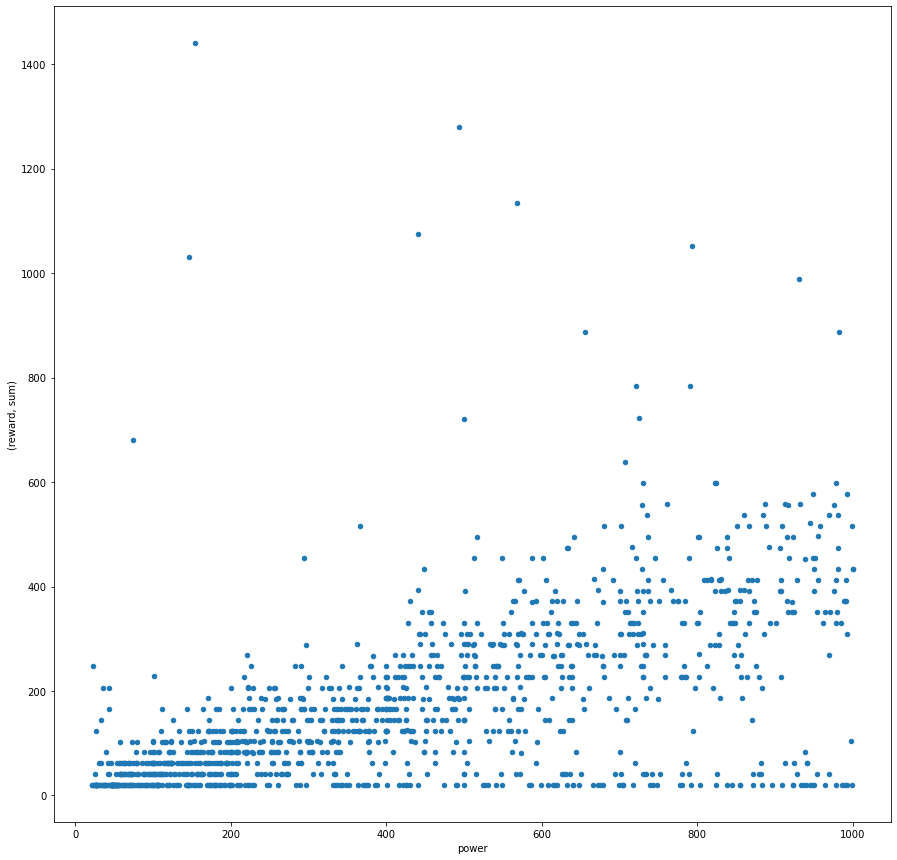

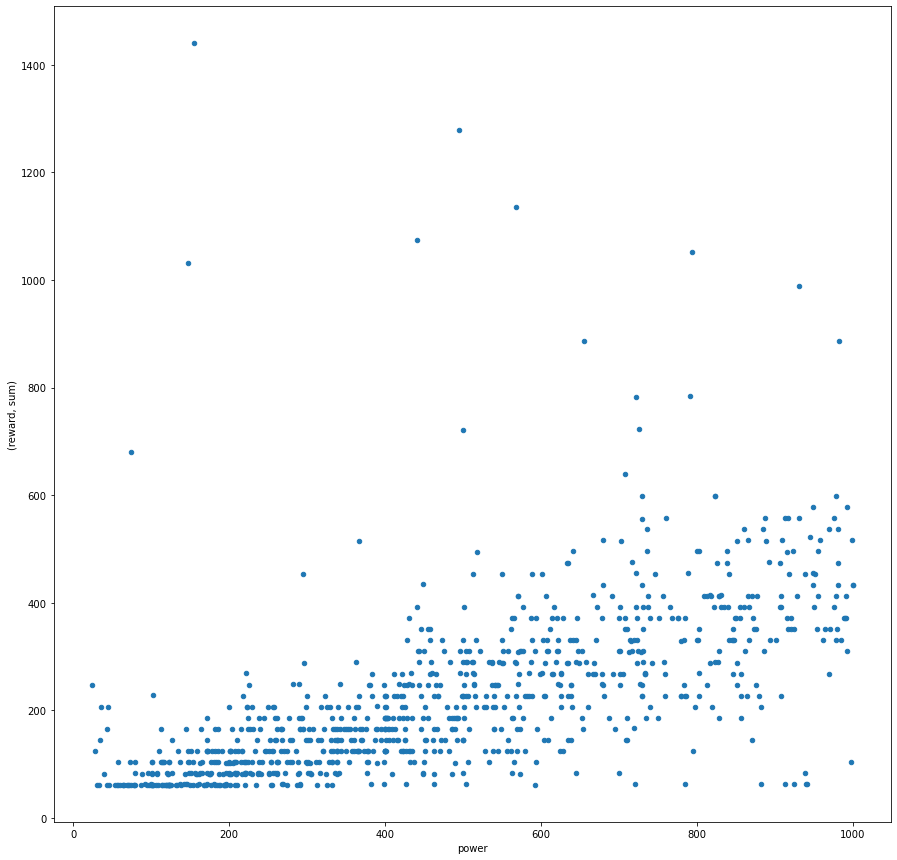

In [59]:
df_sum = (df_joined[(df_joined.power >= 20) & (df_joined.power <= 1000)].groupby(by=['address', 'power']).agg(['sum', 'count'])
    .reset_index()
)
df_sum.plot(x='power', y=('reward', 'sum'), kind='scatter', figsize=(15,15))
df_sum = df_sum[(df_sum[('reward', 'sum')] >= 50)]
#     .plot(kind='hist', figsize=(15,15), bins=20)
df_sum.plot(x='power', y=('reward', 'sum'), kind='scatter', figsize=(15,15))

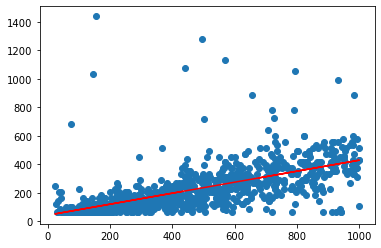

,power,reward,reward@2,reward@5,reward@6,reward@10,cost
0,70,69.144677,138.289354,345.723386,414.868063,691.446772,1207.5
1,100,80.743065,161.486130,403.715326,484.458391,807.430652,1725.0
2,140,96.207583,192.415165,481.037913,577.245496,962.075826,2415.0
3,150,100.073712,200.147424,500.368560,600.442272,1000.737119,2587.5
4,210,123.270488,246.540976,616.352440,739.622928,1232.704880,3622.5
5,500,235.388239,470.776478,1176.941195,1412.329434,2353.882389,8625.0
6,1000,428.694706,857.389412,2143.473530,2572.168236,4286.947061,17250.0


In [70]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  # To visualize

X = df_sum[['power']].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_sum.loc[:, ('reward', 'sum')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

hypothetical_power = [70, 100, 140, 150, 210, 500, 1000]
rewards = linear_regressor.predict(np.array(hypothetical_power).reshape(-1, 1))
hypo_df = pd.DataFrame(data={'power': hypothetical_power, 'reward': rewards.reshape(1, -1)[0]})
hypo_df['reward@2'] = hypo_df['reward'] * 2
hypo_df['reward@5'] = hypo_df['reward'] * 5
hypo_df['reward@6'] = hypo_df['reward'] * 6
hypo_df['reward@10'] = hypo_df['reward'] * 10
hypo_df['cost'] = hypo_df['power'] * 17.25
hypo_df